## Zadání ##

Řešíme kontaktní úlohu
$$\begin{gather*}
    -\Delta u = f(x, y) \quad \text{ na } \Omega, \\
    u = 0 \quad \text{ na } \Gamma_{D}, \\
    \frac{du}{dn}(x, y) = h(x, y) \quad \text{ na } \Gamma_{N}, \\
    u - g \geq 0 \quad \text{ na }  \Gamma_{C} \\
    \frac{du}{dn} \geq 0 \quad \text{ na }  \Gamma_{C} \\
    \frac{du}{dn}(u - g) = 0 \quad \text{ na }  \Gamma_{C},
\end{gather*}$$
kde
$$\begin{gather*}
    \Omega = \{ (x, y) \in \mathbb{R}^2 : |x| < 1 \land |y| < 1 \} \\
    \Gamma_{D} = \{ (x, y) \in \Omega : y = 1 \} \\
    \Gamma_{N} = \{ (x, y) \in \Omega : |x| = 1 \} \\
    \Gamma_{C} = \{ (x, y) \in \Omega : y = -1 \} \\ 
    f(x, y) = -1 \\
    g(x, y) = \sqrt{\frac{1}{2} - x^2} - \frac{\sqrt{2}}{2} - \frac{3}{5} \\
    h(x, y) = 0
\end{gather*}$$

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# imports
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import List
import sys
sys.path.append('../')

In [12]:
# vlastni import
import src.data.cube_domain as cb
import src.models.mlp_model as mm
from src import utils
from src import train
from src import calculus as calc

In [13]:
# vyber device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# funkce

def f(x: torch.Tensor) -> torch.Tensor:
    return -1

def h(x: torch.Tensor) -> torch.Tensor:
    return 0

def g(x: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.clamp(0.5 - torch.pow(x[:, 0:1], 2), min=0.0)) - torch.sqrt(torch.tensor(2.0))/2 - 0.6

In [ ]:
# definice loss

#TODO: vymyslet system pro smerove derivace

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain):
    interior = domain.interior.requires_grad_(True)
    # y je const. a chci tu mensi
    gamma_c = domain.sides[1][0].requires_grad_(True)
    # y je const. a chci tu vetsi
    gamma_d = domain.sides[1][1]
    # x je const. a chci to mensi
    gamma_n_left = domain.sides[0][0].requires_grad_(True)
    # x je const. a chci to vetsi
    gamma_n_right = domain.sides[0][1].requires_grad_(True)

    # prvne ztrata na vnitrku
    pde_out = model(interior)
    lapl = calc.laplacian(interior, pde_out, device=device, time_dependant=False)
    pde_loss = torch.mean((lapl - 1)**2)

    # ztrata dirchletovi podminky
    out_dirichlet = model(gamma_d)
    dirichlet_loss = torch.mean(out_dirichlet**2)

    #ztrata na neumannove podmince
    out_right, out_left = model(gamma_n_right), model(gamma_n_left)
    # z nejakeho duvodu pocitani smerovych derivaci timto zpusobem narusuje schopnost site se dobre trenovat. Proc? To nikdo nevi...
    # du_dn_right = calc.dir_derivative(gamma_n_right, out_right, torch.tensor([1.0, 0.0], device=device), False, True)
    # du_dn_left = calc.dir_derivative(gamma_n_left, out_left, torch.tensor([-1.0, 0.0], device=device), False, True)
    du_dn_right = grad(out_right, gamma_n_right, torch.ones_like(out_right), create_graph=True)[0][:, 0:1]
    du_dn_left = -grad(out_left, gamma_n_left, torch.ones_like(out_left), create_graph=True)[0][:, 0:1]
    neumann_loss = torch.mean((du_dn_right)**2) + torch.mean((du_dn_left)**2)

    # ztrata na kontaktni podmince
    out_contact = model(gamma_c)
    du_dn_contact = - grad(out_contact, gamma_c, torch.ones_like(out_contact), create_graph=True)[0][:, 1:2]
    u_minus_g = out_contact - g(gamma_c)
    contact_loss_1 = torch.mean(torch.relu(-u_minus_g)**2)
    contact_loss_2 = torch.mean(torch.relu(-du_dn_contact)**2)
    contact_loss_3 = torch.mean((du_dn_contact * (u_minus_g))**2)

    contact_loss = contact_loss_1 + contact_loss_2 + contact_loss_3

    #print(pde_loss, dirichlet_loss, neumann_loss, contact_loss)

    return [pde_loss, dirichlet_loss, neumann_loss, contact_loss]

In [16]:
# definice domeny
domain_ctx = cb.CubeContext(
    l_bounds=[-1, -1],
    u_bounds=[1, 1],
    dim = 2,
    N_int=2000,
    N_sides=[(100, 100), (100, 100)],
    device=device
)

domain = cb.CubeDomain(domain_ctx)
domain.generate_points()

In [17]:
# definice modelu a optimalizatoru
model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=1,
    layer=[64, 64, 128],
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
    fourier_features=False
)

model = mm.MLPModel(model_ctx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# samotne trenovani
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=5000,
    monitor_lr=True,
)

total_loss_values, component_loss_values = train.train_switch_to_lbfgs(context, lbfgs_lr=0.1)

Loss at epoch 1 is: 9.649116516113281. Current learing rate: 0.0001 
Loss at epoch 100 is: 2.9077014923095703. Current learing rate: 0.0001 
Loss at epoch 200 is: 1.4260181188583374. Current learing rate: 0.0001 
Loss at epoch 300 is: 1.0387463569641113. Current learing rate: 0.0001 
Loss at epoch 400 is: 0.7357051968574524. Current learing rate: 0.0001 
Loss at epoch 500 is: 0.5557916164398193. Current learing rate: 0.0001 
Loss at epoch 600 is: 0.5033345222473145. Current learing rate: 0.0001 
Loss at epoch 700 is: 0.47663623094558716. Current learing rate: 0.0001 
Loss at epoch 800 is: 0.4669933617115021. Current learing rate: 0.0001 
Loss at epoch 900 is: 0.4531271457672119. Current learing rate: 0.0001 
Loss at epoch 1000 is: 0.4362293481826782. Current learing rate: 0.0001 
Loss at epoch 1100 is: 0.4277142584323883. Current learing rate: 0.0001 
Loss at epoch 1200 is: 0.441030889749527. Current learing rate: 0.0001 
Loss at epoch 1300 is: 0.41977691650390625. Current learing rate

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


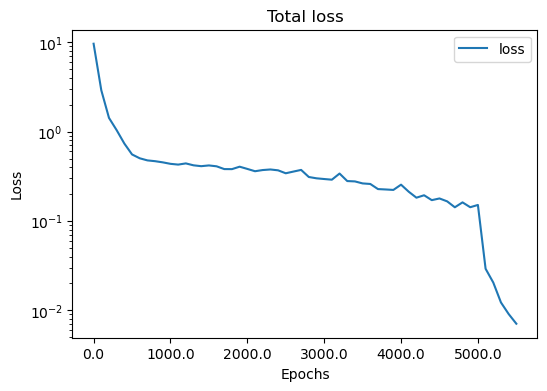

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


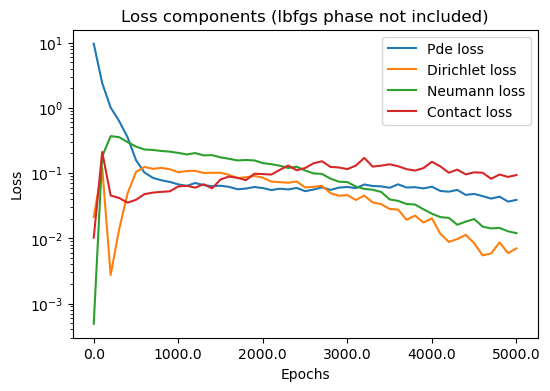

In [19]:
# vykresleni vyvoje ztraty
plot_ctx = utils.PlotContext(
    l_bounds=[-1, -1],
    u_bounds=[1, 1],
    device=device,
    patches=[],
    vmin=-1,
    vmax=0,
    x_label='Epochs',
    y_label='Loss',
)

plot_ctx.titles = ['Total loss']
utils.plot_loss_values({'loss': total_loss_values}, plot_ctx=plot_ctx)
plot_ctx.titles = ['Loss components (lbfgs phase not included)']
utils.plot_loss_values({'Pde loss': component_loss_values[0],
                        'Dirichlet loss': component_loss_values[1],
                        'Neumann loss': component_loss_values[2],
                        'Contact loss': component_loss_values[3]}, plot_ctx=plot_ctx)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


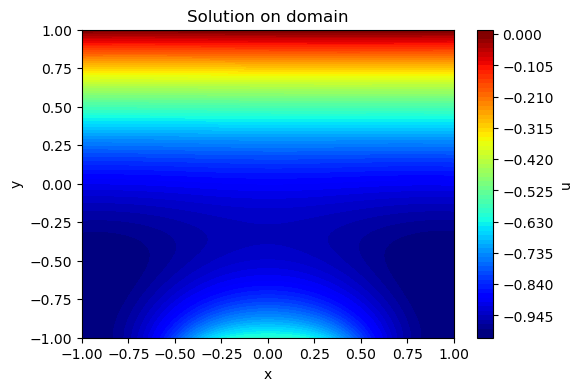

In [20]:
plot_ctx.x_label = 'x'
plot_ctx.y_label = 'y'
plot_ctx.N = 100

plot_ctx.titles = ['Solution on domain']
plot_ctx.function_names = ['u']
utils.plot_function_on_2d_cube([model], plot_ctx)